In [1]:
import os
import pandas as pd
path = r"C:\Users\Wong\Desktop\Dissertation\Imputed_dataset"
Albermarle_rainfall = pd.read_csv(os.path.join(path, 'Albermarle_rainfall.csv'))
Stamfordham_water = pd.read_csv(os.path.join(path, 'Stamfordham.csv'))

In [2]:
Albermarle_rainfall['dateTime'] = pd.to_datetime(Albermarle_rainfall['dateTime'])
Stamfordham_water['dateTime'] = pd.to_datetime(Stamfordham_water['dateTime'])

In [3]:
Stamfordham_water.set_index('dateTime', inplace=True)
Albermarle_rainfall.set_index('dateTime', inplace=True)

In [4]:
start_date = pd.to_datetime('11/03/2020 00:00:00', format='%d/%m/%Y %H:%M:%S')
end_date = pd.to_datetime('05/09/2023 00:00:00', format='%d/%m/%Y %H:%M:%S')
Stamfordham_water_subset = Stamfordham_water.loc[(Stamfordham_water.index >= start_date) & (Stamfordham_water.index <= end_date)]
Albermarle_rainfall_subset = Albermarle_rainfall.loc[(Albermarle_rainfall.index >= start_date) & (Albermarle_rainfall.index <= end_date)]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout

In [6]:
Albermarle_rainfall_subset.shape

(122209, 1)

In [7]:
Stamfordham_water_subset.shape

(122209, 1)

In [8]:
merged_data = pd.merge(Albermarle_rainfall_subset, Stamfordham_water_subset, on='dateTime', how='inner')

In [9]:
train_merged, valid_merged, test_merged = merged_data[1:97767], merged_data[97767:109987],merged_data[109987:122209]

In [10]:
train_Stamfordham = train_merged
scalers_Stamfordham={}
for i in train_merged.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    transform = scaler.fit_transform(train_Stamfordham[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_Stamfordham['scaler_'+ i] = scaler
    train_Stamfordham[i]=transform
test_Stamfordham = test_merged
for i in test_merged.columns:
    scaler = scalers_Stamfordham['scaler_'+i]
    transform = scaler.transform(test_Stamfordham[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_Stamfordham['scaler_'+i] = scaler
    test_Stamfordham[i]=transform
valid_Stamfordham = valid_merged
for i in valid_merged.columns:
    scaler = scalers_Stamfordham['scaler_'+i]
    transform = scaler.transform(valid_Stamfordham[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_Stamfordham['scaler_'+i] = scaler
    valid_Stamfordham[i]=transform

C:\Users\Wong\AppData\Local\Temp\ipykernel_70756\3399495569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_Stamfordham[i]=transform
C:\Users\Wong\AppData\Local\Temp\ipykernel_70756\3399495569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_Stamfordham[i]=transform
C:\Users\Wong\AppData\Local\Temp\ipykernel_70756\3399495569.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [11]:
def split(series, n_past, n_future):
    X, y = list(), list()
    for start in range(len(series)):
        p_end = start + n_past
        f_end = p_end + n_future
        if f_end > len(series):
            break
        past_window, future_window = series[start:p_end, :], series[p_end:f_end, :]
        X.append(past_window)
        y.append(future_window)
    return np.array(X), np.array(y)

In [12]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [13]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_96_in_Stamfordham_= tf.keras.models.Model(e_in,d_outs2)

In [14]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_96_in_Stamfordham_.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_96_in_Stamfordham_=model_e2d2_batch_32_96_in_Stamfordham_.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3051/3051 [==============================] - 722s 234ms/step - loss: 0.0012 - val_loss: 4.3204e-04 - lr: 0.0010
Epoch 2/25
3051/3051 [==============================] - 737s 241ms/step - loss: 4.7800e-04 - val_loss: 2.8616e-04 - lr: 9.0000e-04
Epoch 3/25
3051/3051 [==============================] - 1247s 409ms/step - loss: 4.0697e-04 - val_loss: 4.0114e-04 - lr: 8.1000e-04
Epoch 4/25
3051/3051 [==============================] - 948s 311ms/step - loss: 3.7074e-04 - val_loss: 2.6186e-04 - lr: 7.2900e-04
Epoch 5/25
3051/3051 [==============================] - 626s 205ms/step - loss: 3.4483e-04 - val_loss: 2.1580e-04 - lr: 6.5610e-04
Epoch 6/25
3051/3051 [==============================] - 627s 206ms/step - loss: 3.3207e-04 - val_loss: 2.5856e-04 - lr: 5.9049e-04
Epoch 7/25
3051/3051 [==============================] - 637s 209ms/step - loss: 3.1999e-04 - val_loss: 2.4493e-04 - lr: 5.3144e-04
Epoch 8/25
3051/3051 [==============================] - 636s 209ms/step - loss: 3.0829e-04

In [15]:
import pickle
with open('history_e2d2_batch_32_96_in_Stamfordham_.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_96_in_Stamfordham_.history, file)

In [16]:
from keras.models import load_model
model_e2d2_batch_32_96_in_Stamfordham_.save('model_e2d2_batch_32_96_in_Stamfordham_.h5')

In [17]:
pred_e2d2_batch_32_96_in_Stamfordham_=model_e2d2_batch_32_96_in_Stamfordham_.predict(X_test)

378/378 [==============================] - 39s 96ms/step


In [18]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_32_96_in_Stamfordham_[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_96_in_Stamfordham_[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [19]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_Stamfordham_[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_Stamfordham_[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_Stamfordham_[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.04584616705601316
MSE:  0.024541947320433605
NSE:  0.21965480462639797
time  2 :
MAE:  0.047574368422469
MSE:  0.029048015170031718
NSE:  0.07637813833131202
time  3 :
MAE:  0.0431886570847817
MSE:  0.03011186937007486
NSE:  0.04255142104834819
time  4 :
MAE:  0.044009254993079006
MSE:  0.030370072632294295
NSE:  0.03434149082268256
time  5 :
MAE:  0.043190205504793786
MSE:  0.03037903658954317
NSE:  0.03405646939062745
time  6 :
MAE:  0.04274004811788199
MSE:  0.030323671335287343
NSE:  0.035816884307384944
time  7 :
MAE:  0.04243101828125338
MSE:  0.030418195051883305
NSE:  0.03281137186244942
time  8 :
MAE:  0.04227506307707252
MSE:  0.030481961163137377
NSE:  0.0307838400657634
time  9 :
MAE:  0.042078817051583464
MSE:  0.03055045986426483
NSE:  0.028605829021398077
time  10 :
MAE:  0.041849461666883754
MSE:  0.030722216985937745
NSE:  0.02314457352611554
time  11 :
MAE:  0.04172503231909804
MSE:  0.03092154926245396
NSE:  0.016806527802546878
time  12 :
M

In [21]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [22]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_96_in_Stamfordham_= tf.keras.models.Model(e_in,d_outs2)

In [23]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_96_in_Stamfordham_.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_96_in_Stamfordham_=model_e2d2_batch_64_96_in_Stamfordham_.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1526/1526 [==============================] - 577s 371ms/step - loss: 0.0017 - val_loss: 3.1989e-04 - lr: 0.0010
Epoch 2/25
1526/1526 [==============================] - 521s 342ms/step - loss: 5.0446e-04 - val_loss: 2.9252e-04 - lr: 9.0000e-04
Epoch 3/25
1526/1526 [==============================] - 529s 347ms/step - loss: 4.5923e-04 - val_loss: 2.7870e-04 - lr: 8.1000e-04
Epoch 4/25
1526/1526 [==============================] - 530s 348ms/step - loss: 4.1338e-04 - val_loss: 2.9394e-04 - lr: 7.2900e-04
Epoch 5/25
1526/1526 [==============================] - 528s 346ms/step - loss: 3.7822e-04 - val_loss: 2.1360e-04 - lr: 6.5610e-04
Epoch 6/25
1526/1526 [==============================] - 531s 348ms/step - loss: 3.6045e-04 - val_loss: 2.1943e-04 - lr: 5.9049e-04
Epoch 7/25
1526/1526 [==============================] - 531s 348ms/step - loss: 3.3665e-04 - val_loss: 2.3125e-04 - lr: 5.3144e-04
Epoch 8/25
1526/1526 [==============================] - 542s 355ms/step - loss: 3.2590e-04 

In [24]:
import pickle
with open('history_e2d2_batch_64_96_in_Stamfordham_.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_96_in_Stamfordham_.history, file)

In [25]:
from keras.models import load_model
model_e2d2_batch_64_96_in_Stamfordham_.save('model_e2d2_batch_64_96_in_Stamfordham_.h5')

In [26]:
pred_e2d2_batch_64_96_in_Stamfordham_=model_e2d2_batch_64_96_in_Stamfordham_.predict(X_test)

378/378 [==============================] - 43s 98ms/step


In [27]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_64_96_in_Stamfordham_[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_96_in_Stamfordham_[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [28]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_Stamfordham_[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_Stamfordham_[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_Stamfordham_[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.036376295526727
MSE:  0.026547902550457483
NSE:  0.155872680679763
time  2 :
MAE:  0.0357090821022604
MSE:  0.029612002536305835
NSE:  0.05844537913428649
time  3 :
MAE:  0.03643219074633295
MSE:  0.030498497255536595
NSE:  0.03025805211236643
time  4 :
MAE:  0.037184168017555
MSE:  0.030553501116554964
NSE:  0.02850912819397211
time  5 :
MAE:  0.03718172020544644
MSE:  0.03045108023618707
NSE:  0.03176574189530135
time  6 :
MAE:  0.03660391799779273
MSE:  0.030369991893923746
NSE:  0.03434405801096296
time  7 :
MAE:  0.036116185398703426
MSE:  0.030472504962038197
NSE:  0.031084513072590636
time  8 :
MAE:  0.03582421889101021
MSE:  0.03063249571059393
NSE:  0.025997385702068554
time  9 :
MAE:  0.03562815182058411
MSE:  0.030762828295805948
NSE:  0.021853280699196898
time  10 :
MAE:  0.035561358321728576
MSE:  0.030992993661024353
NSE:  0.014534854229425909
time  11 :
MAE:  0.03558715653445153
MSE:  0.031207374534429275
NSE:  0.007718317531775765
time  12 :
MA

In [29]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [30]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_96_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [31]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_96_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_96_in_Stamfordham=model_e2d2_batch_128_96_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
763/763 [==============================] - 567s 728ms/step - loss: 0.0028 - val_loss: 3.6270e-04 - lr: 0.0010
Epoch 2/25
763/763 [==============================] - 493s 646ms/step - loss: 5.4467e-04 - val_loss: 2.8450e-04 - lr: 9.0000e-04
Epoch 3/25
763/763 [==============================] - 497s 652ms/step - loss: 4.7281e-04 - val_loss: 4.6075e-04 - lr: 8.1000e-04
Epoch 4/25
763/763 [==============================] - 496s 651ms/step - loss: 4.4386e-04 - val_loss: 3.4302e-04 - lr: 7.2900e-04
Epoch 5/25
763/763 [==============================] - 496s 651ms/step - loss: 4.0919e-04 - val_loss: 2.5108e-04 - lr: 6.5610e-04
Epoch 6/25
763/763 [==============================] - 496s 650ms/step - loss: 3.8288e-04 - val_loss: 2.3739e-04 - lr: 5.9049e-04
Epoch 7/25
763/763 [==============================] - 497s 651ms/step - loss: 3.6856e-04 - val_loss: 3.0283e-04 - lr: 5.3144e-04
Epoch 8/25
763/763 [==============================] - 501s 656ms/step - loss: 3.4979e-04 - val_loss: 2.73

In [32]:
import pickle
with open('history_e2d2_batch_128_96_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_96_in_Stamfordham.history, file)

In [33]:
from keras.models import load_model
model_e2d2_batch_128_96_in_Stamfordham.save('model_e2d2_batch_128_96_in_Stamfordham.h5')

In [34]:
pred_e2d2_batch_128_96_in_Stamfordham=model_e2d2_batch_128_96_in_Stamfordham.predict(X_test)

378/378 [==============================] - 34s 86ms/step


In [35]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_128_96_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_96_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [36]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.046873190659779525
MSE:  0.027377312215146405
NSE:  0.12950045200589766
time  2 :
MAE:  0.047940491009492804
MSE:  0.02895331547103556
NSE:  0.07938924638032363
time  3 :
MAE:  0.045135778369804085
MSE:  0.029282185748625955
NSE:  0.06893236055671259
time  4 :
MAE:  0.042788416951073154
MSE:  0.02937688867446763
NSE:  0.06592114990567999
time  5 :
MAE:  0.04073139331289273
MSE:  0.02947922979825081
NSE:  0.06266707217539136
time  6 :
MAE:  0.038797914023548964
MSE:  0.029641107251057272
NSE:  0.05751995443092184
time  7 :
MAE:  0.037166413351719475
MSE:  0.029906968074742347
NSE:  0.049066541435939914
time  8 :
MAE:  0.035740841357792257
MSE:  0.030218581417782366
NSE:  0.03915836373998649
time  9 :
MAE:  0.03449883409284264
MSE:  0.030545909974931874
NSE:  0.028750499052430767
time  10 :
MAE:  0.033482676652184636
MSE:  0.0309127402033281
NSE:  0.01708662403431227
time  11 :
MAE:  0.032714999463248504
MSE:  0.0311720626137808
NSE:  0.008841108941017639
time  

Now try different batch size for 48input

In [37]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [38]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_48_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [39]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_48_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_48_in_Stamfordham=model_e2d2_batch_32_48_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3053/3053 [==============================] - 598s 193ms/step - loss: 0.0011 - val_loss: 3.2806e-04 - lr: 0.0010
Epoch 2/25
3053/3053 [==============================] - 588s 193ms/step - loss: 4.8486e-04 - val_loss: 2.5958e-04 - lr: 9.0000e-04
Epoch 3/25
3053/3053 [==============================] - 598s 196ms/step - loss: 4.1992e-04 - val_loss: 3.0000e-04 - lr: 8.1000e-04
Epoch 4/25
3053/3053 [==============================] - 604s 198ms/step - loss: 3.8173e-04 - val_loss: 2.9443e-04 - lr: 7.2900e-04
Epoch 5/25
3053/3053 [==============================] - 599s 196ms/step - loss: 3.6417e-04 - val_loss: 2.3700e-04 - lr: 6.5610e-04
Epoch 6/25
3053/3053 [==============================] - 597s 195ms/step - loss: 3.4348e-04 - val_loss: 2.0984e-04 - lr: 5.9049e-04
Epoch 7/25
3053/3053 [==============================] - 598s 196ms/step - loss: 3.2933e-04 - val_loss: 2.2153e-04 - lr: 5.3144e-04
Epoch 8/25
3053/3053 [==============================] - 595s 195ms/step - loss: 3.1917e-04 

In [40]:
import pickle
with open('history_e2d2_batch_32_48_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_48_in_Stamfordham.history, file)

In [41]:
from keras.models import load_model
model_e2d2_batch_32_48_in_Stamfordham.save('model_e2d2_batch_32_48_in_Stamfordham.h5')

In [42]:
pred_e2d2_batch_32_48_in_Stamfordham=model_e2d2_batch_32_48_in_Stamfordham.predict(X_test)

379/379 [==============================] - 25s 61ms/step


In [43]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_32_48_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_48_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [45]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.039457402890283155
MSE:  0.02358990359540211
NSE:  0.24712564930606506
time  2 :
MAE:  0.03946139789860315
MSE:  0.02834618996560148
NSE:  0.09532825012651902
time  3 :
MAE:  0.03258215010564286
MSE:  0.02982700223248172
NSE:  0.04806796483462106
time  4 :
MAE:  0.03277725198257684
MSE:  0.030162922462831424
NSE:  0.03734703398016925
time  5 :
MAE:  0.03303325886560054
MSE:  0.030283066683510156
NSE:  0.03351261805017958
time  6 :
MAE:  0.033346302805979444
MSE:  0.030268705694085244
NSE:  0.033970950596766025
time  7 :
MAE:  0.033895913056689486
MSE:  0.03034983743305957
NSE:  0.0313816222828992
time  8 :
MAE:  0.034710625472894115
MSE:  0.03049946658352406
NSE:  0.0266061915972563
time  9 :
MAE:  0.035540863517446036
MSE:  0.030667129281641326
NSE:  0.021255218267919096
time  10 :
MAE:  0.03620975155365224
MSE:  0.030882360261772917
NSE:  0.014386098020756632
time  11 :
MAE:  0.03671974512969827
MSE:  0.031108555139499186
NSE:  0.007167063783937833
time  12 

In [46]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [47]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_48_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [48]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_48_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_48_in_Stamfordham=model_e2d2_batch_64_48_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1527/1527 [==============================] - 364s 232ms/step - loss: 0.0016 - val_loss: 4.9968e-04 - lr: 0.0010
Epoch 2/25
1527/1527 [==============================] - 374s 245ms/step - loss: 5.1416e-04 - val_loss: 3.2506e-04 - lr: 9.0000e-04
Epoch 3/25
1527/1527 [==============================] - 374s 245ms/step - loss: 4.3876e-04 - val_loss: 2.4218e-04 - lr: 8.1000e-04
Epoch 4/25
1527/1527 [==============================] - 375s 246ms/step - loss: 4.0622e-04 - val_loss: 3.0258e-04 - lr: 7.2900e-04
Epoch 5/25
1527/1527 [==============================] - 375s 246ms/step - loss: 3.7810e-04 - val_loss: 3.0139e-04 - lr: 6.5610e-04
Epoch 6/25
1527/1527 [==============================] - 375s 246ms/step - loss: 3.6327e-04 - val_loss: 2.5175e-04 - lr: 5.9049e-04
Epoch 7/25
1527/1527 [==============================] - 377s 247ms/step - loss: 3.4296e-04 - val_loss: 2.4258e-04 - lr: 5.3144e-04
Epoch 8/25
1527/1527 [==============================] - 377s 247ms/step - loss: 3.3126e-04 

In [49]:
import pickle
with open('history_e2d2_batch_64_48_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_48_in_Stamfordham.history, file)

In [50]:
from keras.models import load_model
model_e2d2_batch_64_48_in_Stamfordham.save('model_e2d2_batch_64_48_in_Stamfordham.h5')

In [51]:
pred_e2d2_batch_64_48_in_Stamfordham=model_e2d2_batch_64_48_in_Stamfordham.predict(X_test)

379/379 [==============================] - 26s 63ms/step


In [52]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_64_48_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_48_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [53]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.03903061745929002
MSE:  0.025818418002005065
NSE:  0.17600236853054307
time  2 :
MAE:  0.03583100817018126
MSE:  0.02934964789287258
NSE:  0.06330278073926143
time  3 :
MAE:  0.035789928896719884
MSE:  0.030324690487869364
NSE:  0.03218418978621418
time  4 :
MAE:  0.03884599832844791
MSE:  0.03012599023193235
NSE:  0.03852573016455019
time  5 :
MAE:  0.040564434304421776
MSE:  0.02978674823450956
NSE:  0.049352675578077876
time  6 :
MAE:  0.04117144662667217
MSE:  0.02962568222530386
NSE:  0.05449311486004449
time  7 :
MAE:  0.04179960364332849
MSE:  0.02978609906093638
NSE:  0.049373394023595196
time  8 :
MAE:  0.042413659880990356
MSE:  0.029994691637620644
NSE:  0.04271613914776984
time  9 :
MAE:  0.042801722078849455
MSE:  0.030174054320395535
NSE:  0.036991759529737434
time  10 :
MAE:  0.0430013812088638
MSE:  0.030409800429410952
NSE:  0.029467896702752627
time  11 :
MAE:  0.04303680937023009
MSE:  0.03060818730103849
NSE:  0.02313635801889391
time  12 :

In [54]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [55]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_48_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [56]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_48_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_48_in_Stamfordham=model_e2d2_batch_128_48_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
764/764 [==============================] - 368s 471ms/step - loss: 0.0023 - val_loss: 4.2789e-04 - lr: 0.0010
Epoch 2/25
764/764 [==============================] - 354s 463ms/step - loss: 5.2464e-04 - val_loss: 3.0156e-04 - lr: 9.0000e-04
Epoch 3/25
764/764 [==============================] - 356s 466ms/step - loss: 4.6652e-04 - val_loss: 2.6615e-04 - lr: 8.1000e-04
Epoch 4/25
764/764 [==============================] - 357s 468ms/step - loss: 4.2330e-04 - val_loss: 2.4772e-04 - lr: 7.2900e-04
Epoch 5/25
764/764 [==============================] - 356s 466ms/step - loss: 4.1298e-04 - val_loss: 2.4719e-04 - lr: 6.5610e-04
Epoch 6/25
764/764 [==============================] - 357s 467ms/step - loss: 3.8825e-04 - val_loss: 2.2102e-04 - lr: 5.9049e-04
Epoch 7/25
764/764 [==============================] - 357s 468ms/step - loss: 3.8216e-04 - val_loss: 2.3839e-04 - lr: 5.3144e-04
Epoch 8/25
764/764 [==============================] - 356s 465ms/step - loss: 3.6009e-04 - val_loss: 3.32

In [57]:
import pickle
with open('history_e2d2_batch_128_48_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_48_in_Stamfordham.history, file)

In [58]:
from keras.models import load_model
model_e2d2_batch_128_48_in_Stamfordham.save('model_e2d2_batch_128_48_in_Stamfordham.h5')

In [59]:
pred_e2d2_batch_128_48_in_Stamfordham=model_e2d2_batch_128_48_in_Stamfordham.predict(X_test)

379/379 [==============================] - 29s 70ms/step


In [60]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_128_48_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_48_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [61]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.03393158358832405
MSE:  0.027219070773384323
NSE:  0.1313003822958324
time  2 :
MAE:  0.0342289590399116
MSE:  0.028799885914489943
NSE:  0.08084849434665886
time  3 :
MAE:  0.033232569932406794
MSE:  0.029313986207169435
NSE:  0.06444092733489382
time  4 :
MAE:  0.03239550620398557
MSE:  0.02941560525148469
NSE:  0.06119774443261605
time  5 :
MAE:  0.0314869995275255
MSE:  0.029445447678050365
NSE:  0.06024532012817163
time  6 :
MAE:  0.030913147167842166
MSE:  0.029535894242807507
NSE:  0.05735870813170307
time  7 :
MAE:  0.030546356841935324
MSE:  0.02977440319912141
NSE:  0.04974666873131672
time  8 :
MAE:  0.03013680216563625
MSE:  0.03010427308410708
NSE:  0.03921883531022219
time  9 :
MAE:  0.02982903929213615
MSE:  0.03047934842206914
NSE:  0.027248264918212084
time  10 :
MAE:  0.029753084936509213
MSE:  0.030895016767553067
NSE:  0.01398216425592591
time  11 :
MAE:  0.02983917747452576
MSE:  0.031162777849330834
NSE:  0.005436540075255847
time  12 :
M

MAE:  0.023626213638763036
MSE:  0.0023496015004291953
NSE:  0.9671400961401527
time  48 :
MAE:  0.024072139627730804
MSE:  0.00243522750780577
NSE:  0.9659422577167533



now try different batch size for 24 input

In [62]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [63]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_24_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [64]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_24_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_24_in_Stamfordham=model_e2d2_batch_32_24_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3053/3053 [==============================] - 523s 168ms/step - loss: 0.0012 - val_loss: 2.8052e-04 - lr: 0.0010
Epoch 2/25
3053/3053 [==============================] - 553s 181ms/step - loss: 5.0117e-04 - val_loss: 4.0304e-04 - lr: 9.0000e-04
Epoch 3/25
3053/3053 [==============================] - 553s 181ms/step - loss: 4.3688e-04 - val_loss: 2.7451e-04 - lr: 8.1000e-04
Epoch 4/25
3053/3053 [==============================] - 552s 181ms/step - loss: 3.9474e-04 - val_loss: 2.2961e-04 - lr: 7.2900e-04
Epoch 5/25
3053/3053 [==============================] - 553s 181ms/step - loss: 3.6665e-04 - val_loss: 3.6700e-04 - lr: 6.5610e-04
Epoch 6/25
3053/3053 [==============================] - 553s 181ms/step - loss: 3.4918e-04 - val_loss: 2.1443e-04 - lr: 5.9049e-04
Epoch 7/25
3053/3053 [==============================] - 559s 183ms/step - loss: 3.3507e-04 - val_loss: 2.0475e-04 - lr: 5.3144e-04
Epoch 8/25
3053/3053 [==============================] - 553s 181ms/step - loss: 3.2514e-04 

In [65]:
import pickle
with open('history_e2d2_batch_32_24_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_24_in_Stamfordham.history, file)

In [66]:
from keras.models import load_model
model_e2d2_batch_32_24_in_Stamfordham.save('model_e2d2_batch_32_24_in_Stamfordham.h5')

In [67]:
pred_e2d2_batch_32_24_in_Stamfordham=model_e2d2_batch_32_24_in_Stamfordham.predict(X_test)

380/380 [==============================] - 26s 58ms/step


In [68]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_32_24_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_24_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [69]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.034968747948238496
MSE:  0.02407404779105574
NSE:  0.23018504040154464
time  2 :
MAE:  0.034938435008639454
MSE:  0.028280529736064784
NSE:  0.09567451867067622
time  3 :
MAE:  0.034011554003801764
MSE:  0.029148914711468233
NSE:  0.06790620357227051
time  4 :
MAE:  0.0338941980571808
MSE:  0.029620180709842656
NSE:  0.05283654770685686
time  5 :
MAE:  0.03403295228220525
MSE:  0.02989015477171917
NSE:  0.044203596848741755
time  6 :
MAE:  0.03482962269202622
MSE:  0.030018367174901885
NSE:  0.04010375344755046
time  7 :
MAE:  0.03477028732230738
MSE:  0.030141373369736796
NSE:  0.03617038878328416
time  8 :
MAE:  0.03453712816562547
MSE:  0.03023655690485728
NSE:  0.0331267083071477
time  9 :
MAE:  0.03445251129476261
MSE:  0.030336422892111477
NSE:  0.029933297227690114
time  10 :
MAE:  0.034536021892430505
MSE:  0.030531532057222983
NSE:  0.023694298478447617
time  11 :
MAE:  0.03472237483766989
MSE:  0.030750866429881715
NSE:  0.016680651139524993
time  12

In [70]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [71]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_24_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [72]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_24_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_24_in_Stamfordham=model_e2d2_batch_64_24_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1527/1527 [==============================] - 374s 238ms/step - loss: 0.0017 - val_loss: 5.0174e-04 - lr: 0.0010
Epoch 2/25
1527/1527 [==============================] - 447s 293ms/step - loss: 5.0800e-04 - val_loss: 4.4852e-04 - lr: 9.0000e-04
Epoch 3/25
1527/1527 [==============================] - 460s 301ms/step - loss: 4.6558e-04 - val_loss: 2.6867e-04 - lr: 8.1000e-04
Epoch 4/25
1527/1527 [==============================] - 470s 308ms/step - loss: 4.3164e-04 - val_loss: 2.8384e-04 - lr: 7.2900e-04
Epoch 5/25
1527/1527 [==============================] - 472s 309ms/step - loss: 3.9648e-04 - val_loss: 2.3460e-04 - lr: 6.5610e-04
Epoch 6/25
1527/1527 [==============================] - 446s 292ms/step - loss: 3.7512e-04 - val_loss: 3.4204e-04 - lr: 5.9049e-04
Epoch 7/25
1527/1527 [==============================] - 449s 294ms/step - loss: 3.5983e-04 - val_loss: 3.2184e-04 - lr: 5.3144e-04
Epoch 8/25
1527/1527 [==============================] - 444s 291ms/step - loss: 3.4456e-04 

In [73]:
import pickle
with open('history_e2d2_batch_64_24_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_24_in_Stamfordham.history, file)

In [74]:
from keras.models import load_model
model_e2d2_batch_64_24_in_Stamfordham.save('model_e2d2_batch_64_24_in_Stamfordham.h5')

In [75]:
pred_e2d2_batch_64_24_in_Stamfordham=model_e2d2_batch_64_24_in_Stamfordham.predict(X_test)

380/380 [==============================] - 25s 60ms/step


In [76]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_64_24_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_24_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [77]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.03374321207412721
MSE:  0.02549260250730013
NSE:  0.18482396730524575
time  2 :
MAE:  0.03920431245590823
MSE:  0.028845048721656674
NSE:  0.07762291538992516
time  3 :
MAE:  0.03560762743470737
MSE:  0.029828786054520853
NSE:  0.046165982109445
time  4 :
MAE:  0.03612533229220091
MSE:  0.029801636771565755
NSE:  0.047034133753181884
time  5 :
MAE:  0.03501553935343792
MSE:  0.02957549180938948
NSE:  0.054265563067939726
time  6 :
MAE:  0.034040653749744874
MSE:  0.029417475255950242
NSE:  0.05931845270899583
time  7 :
MAE:  0.033488153285052516
MSE:  0.029523102854411412
NSE:  0.05594080279537894
time  8 :
MAE:  0.033094569424348304
MSE:  0.02973081532323494
NSE:  0.04929878865703008
time  9 :
MAE:  0.0326696494019833
MSE:  0.0299385746351072
NSE:  0.04265527662019808
time  10 :
MAE:  0.03239738235413984
MSE:  0.030281707527914144
NSE:  0.03168292845898779
time  11 :
MAE:  0.03237121827454637
MSE:  0.030606501005659783
NSE:  0.02129701911301174
time  12 :
MAE

In [78]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Stamfordham.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Stamfordham.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Stamfordham.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [79]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_24_in_Stamfordham= tf.keras.models.Model(e_in,d_outs2)

In [80]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_24_in_Stamfordham.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_24_in_Stamfordham=model_e2d2_batch_128_24_in_Stamfordham.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
764/764 [==============================] - 287s 363ms/step - loss: 0.0026 - val_loss: 3.3099e-04 - lr: 0.0010
Epoch 2/25
764/764 [==============================] - 282s 369ms/step - loss: 5.4134e-04 - val_loss: 3.1987e-04 - lr: 9.0000e-04
Epoch 3/25
764/764 [==============================] - 278s 364ms/step - loss: 4.7607e-04 - val_loss: 2.8150e-04 - lr: 8.1000e-04
Epoch 4/25
764/764 [==============================] - 280s 366ms/step - loss: 4.3817e-04 - val_loss: 2.8594e-04 - lr: 7.2900e-04
Epoch 5/25
764/764 [==============================] - 279s 365ms/step - loss: 4.2011e-04 - val_loss: 3.7695e-04 - lr: 6.5610e-04
Epoch 6/25
764/764 [==============================] - 279s 365ms/step - loss: 4.0540e-04 - val_loss: 2.5851e-04 - lr: 5.9049e-04
Epoch 7/25
764/764 [==============================] - 280s 366ms/step - loss: 3.8875e-04 - val_loss: 4.5116e-04 - lr: 5.3144e-04
Epoch 8/25
764/764 [==============================] - 319s 418ms/step - loss: 3.7122e-04 - val_loss: 2.20

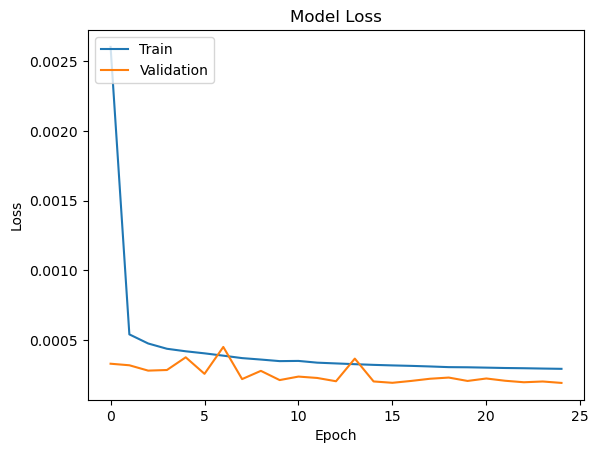

In [81]:
import matplotlib.pyplot as plt

plt.plot(history_e2d2_batch_128_24_in_Stamfordham.history['loss'])
plt.plot(history_e2d2_batch_128_24_in_Stamfordham.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [82]:
import pickle
with open('history_e2d2_batch_128_24_in_Stamfordham.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_24_in_Stamfordham.history, file)

In [83]:
from keras.models import load_model
model_e2d2_batch_128_24_in_Stamfordham.save('model_e2d2_batch_128_24_in_Stamfordham.h5')

In [84]:
pred_e2d2_batch_128_24_in_Stamfordham=model_e2d2_batch_128_24_in_Stamfordham.predict(X_test)

380/380 [==============================] - 30s 61ms/step


In [85]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Stamfordham['scaler_'+i]
    pred_e2d2_batch_128_24_in_Stamfordham[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_24_in_Stamfordham[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [87]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Stamfordham[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Stamfordham[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Stamfordham[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.03824650089531394
MSE:  0.027108095566557574
NSE:  0.13316540390379306
time  2 :
MAE:  0.04059166114778246
MSE:  0.028579035569719392
NSE:  0.08612920837349791
time  3 :
MAE:  0.03748117878882249
MSE:  0.02899967822881135
NSE:  0.07267833320598382
time  4 :
MAE:  0.03726738075711248
MSE:  0.029107883548501585
NSE:  0.06921825559341765
time  5 :
MAE:  0.03716555898664969
MSE:  0.02918264909036011
NSE:  0.06682748055281318
time  6 :
MAE:  0.03674400213588638
MSE:  0.029300472435892587
NSE:  0.06305984767411899
time  7 :
MAE:  0.03638439868352175
MSE:  0.029533267112405906
NSE:  0.055615780683381355
time  8 :
MAE:  0.03615449469488409
MSE:  0.02982950621811773
NSE:  0.04614295346403208
time  9 :
MAE:  0.036052387577546946
MSE:  0.030150188374555926
NSE:  0.035888511691504976
time  10 :
MAE:  0.03608030315564303
MSE:  0.03051718851573559
NSE:  0.02415296138825196
time  11 :
MAE:  0.036173175148645674
MSE:  0.030766099824300522
NSE:  0.016193533434565532
time  12 :